In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d, splrep, splev
import pandas as pd
from scipy import interpolate

%load_ext autoreload
%autoreload 2
from utils import *

In [63]:
def fill_nan(A):
    inds = np.arange(A.shape[0]) 
    good = np.where(np.isfinite(A))
    if(len(good[0]) <= 1):
        return A
   
    # linearly interpolate and then fill the extremes with the mean (relatively similar to)
    # what kalman does 
    f = interpolate.interp1d(inds[good], A[good],kind="linear",bounds_error=False,fill_value="extrapolate")
    B = np.where(np.isfinite(A),A,f(inds))
    B = np.where(np.isfinite(B),B,np.nanmean(B))
    return B

def mean_perc(ts):
    ts = ts[ts > np.percentile(ts,5)]
    ts = ts[ts < np.percentile(ts,95)]
    return np.mean(ts)

def center_ts(res):
    res.shape

    scale = (res[:,(NECK*3):(NECK*3+3)] - res[:,(MHIP*3):(MHIP*3+3)])[:,:2]
    scale = np.sqrt(np.sum(scale**2,axis=1))
    scale = mean_perc(scale)
    
    X = mean_perc(res[:,RANK*3])
    Y = mean_perc(res[:,RANK*3+1])
    
    for i in range(25):
        res[:,(i*3):(i*3+3)] = res[:,(i*3):(i*3+3)] - np.hstack([X,Y,0])[None,:]
    return res /scale #[:,None]

def plot_ts(res):
    # Features to plot for diagnostics
    PLOT_COLS = {
        "Left knee": LKNE,
        "Right knee": RKNE,
        "Left hip": LHIP,
        "Right hip": RHIP,
        "Nose": NOSE,
    }

    for name, col in PLOT_COLS.items():
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title(name,fontsize=24)
        plt.xlabel("frame",fontsize=17)
        plt.ylabel("position",fontsize=17)
        plt.plot(res[:,[col*3,]], linestyle="-", linewidth=2.5)
        plt.plot(res[:,[col*3+1,]], linestyle="-", linewidth=2.5)
        plt.legend(['x', 'y'],loc=1)

def get_segments(res, magnitude = 1):
    nose_y = res[:,[NOSE*3+1,]]
    x=range(len(nose_y))
    f = splrep(x, nose_y, s=magnitude)
    nose_y_smooth = splev(x, f)
    peaks,_ = peakdet(nose_y_smooth, np.sqrt(magnitude)*(nose_y.max() - nose_y.min())/3  )

    plt.title("Peaks of the nose",fontsize=24)
    plt.xlabel("frame",fontsize=17)
    plt.ylabel("position",fontsize=17)
    plt.plot(nose_y, linestyle="-", linewidth=2.5)
    plt.plot(nose_y_smooth, linestyle="-", linewidth=2.5)
    for i in range(peaks.shape[0]):
        plt.axvline(x=peaks[i,0],linewidth=2, color='g', linestyle="--")
    plt.show()

    n = peaks.shape[0]

    # TODO we can get a better estimate of breaks from multiple signals at once
    breaks = peaks[:,0].astype(np.uint16)
    breaks.sort()

    return breaks

def get_angle_stats(A, B, C, res, breaks, name = None):
    langle = get_angle(A, B, C, res)
    minv = []
    maxv = []
    for i in range(len(breaks)-1):
        y = (langle[breaks[i]:breaks[i+1]])*180/np.pi
        minv.append(y.min())
        maxv.append(y.max())
    return {
        "{}_max".format(name): max(maxv),
        "{}_min".format(name): max(minv),
        "{}_max_sd".format(name): np.array(maxv).std(),
        "{}_min_sd".format(name): np.array(minv).std(),
    }
    
def get_angles_results(res, breaks):
    results = {}
    results.update(get_angle_stats(LANK, LKNE, LHIP, res, breaks, name="left_knee"))
    results.update(get_angle_stats(RANK, RKNE, RHIP, res, breaks, name="right_knee"))
    results.update(get_angle_stats(LKNE, LHIP, NECK, res, breaks, name="left_hip"))
    results.update(get_angle_stats(RKNE, RHIP, NECK, res, breaks, name="right_hip"))
    res_tmp = res.copy()
    ground = np.zeros([res_tmp.shape[0],3])
    ground[:,1] = ground[:,1] - 1
    res_tmp = np.hstack([res_tmp, ground])
    results.update(get_angle_stats(NECK, MHIP, 25, res_tmp, breaks, name="trunk"))
    return results

def get_time_results(res, breaks):
    times = []
    speeds = []

    for i in range(len(breaks)-1):
        time = (breaks[i+1] - breaks[i])/FPS
        speed = 1/time

        times.append(time)
        speeds.append(speed)

    first = breaks[0]
    last = breaks[-1]
    n = len(breaks)
    total_time = n*(last-first)/((n-1)*FPS)

    return {
        "n": len(breaks),
        "time": total_time,
        "speed": round(5/total_time,2),
        "time_sd": np.array(times).std(),
        "speed_sd": np.array(speeds).std(),
    }

def get_joint_speed(joint, res):
    n = res.shape[0]
    return res[1:n,(joint*3):(joint*3+3)] - res[0:(n-1),(joint*3):(joint*3+3)]

def get_speed_stats(joint, res, breaks, name="pelvic"):
    trunk_speed = get_joint_speed(joint, res)[:,0:2]
    trunk_speed_mag = np.sqrt(np.sum(trunk_speed**2, axis=1))
    
    n = trunk_speed.shape[0]
    trunk_acc = trunk_speed[1:n,:] - trunk_speed[0:(n-1),:]
    trunk_acc_mag = np.sqrt(np.sum(trunk_acc**2, axis=1))
    
    first = breaks[0]
    last = breaks[-1]
    
    trunk_speed_mag = trunk_speed_mag[first:last]
    trunk_speed_mag = trunk_speed_mag[trunk_speed_mag < np.percentile(trunk_speed_mag, 95)] # remove outliers
    
    trunk_acc_mag = trunk_acc_mag[first:last]
    trunk_acc_mag = trunk_acc_mag[trunk_acc_mag < np.percentile(trunk_acc_mag, 95)] # remove outliers
    
    return {
        "{}_avg_speed".format(name): trunk_speed_mag.mean(),
        "{}_max_speed".format(name): trunk_speed_mag.max(),
        "{}_avg_acc".format(name): trunk_acc_mag.mean(),
        "{}_max_acc".format(name): trunk_acc_mag.max(),
    }
    
def get_acceleration_results(res, breaks):
    results = {}
    results.update(get_speed_stats(MHIP, res, breaks, name="pelvic"))
    results.update(get_speed_stats(NECK, res, breaks, name="neck"))
    return results

9QrMwwEK


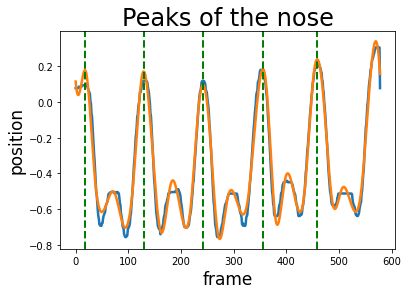

hozGKSGr


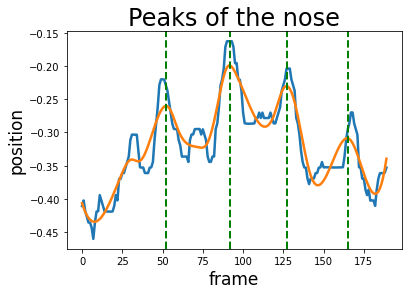

0eHy4fTr


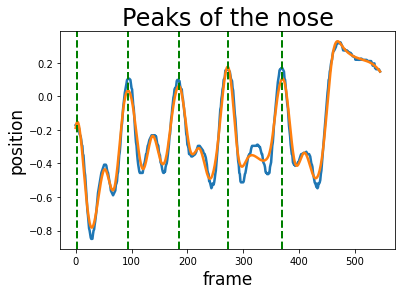

BgJDWIJz


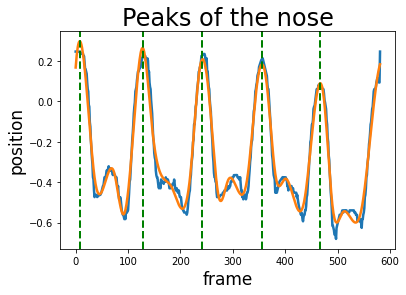

bzh3pQlt


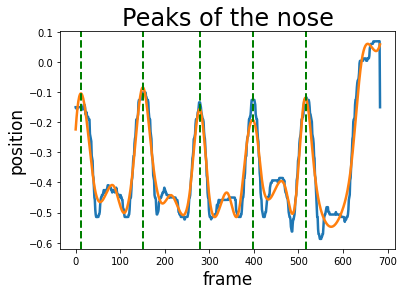

OJk9GuJF


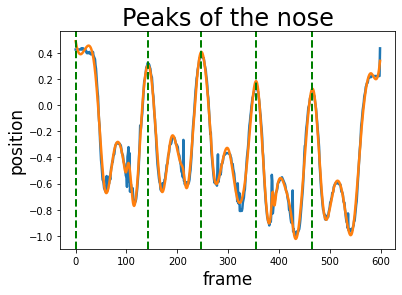

z7T3lqIX


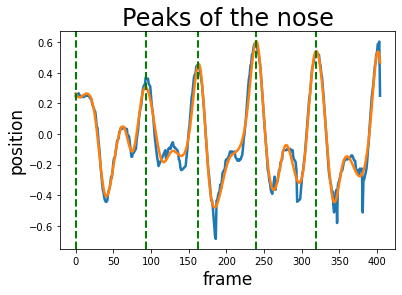

iWDepaRU


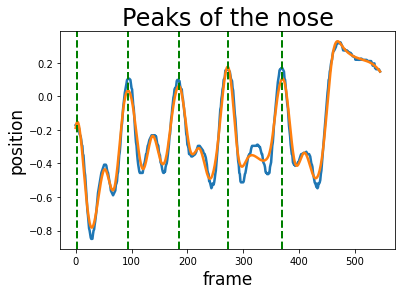

LK6o034V


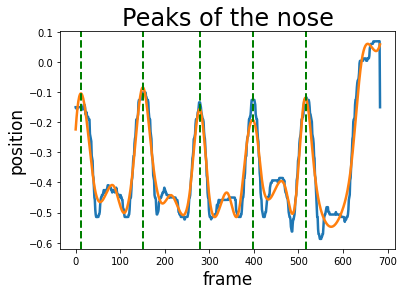

QRGPZHlK


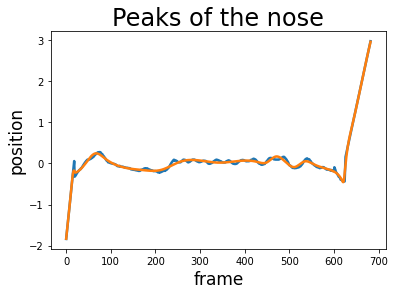

Skipped QRGPZHlK
hBNwNT1A


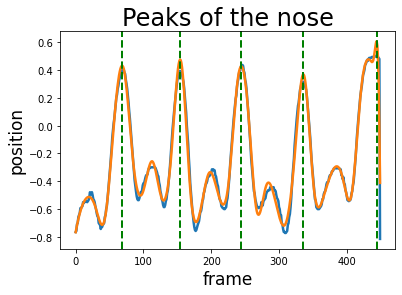

nEdq9NGM


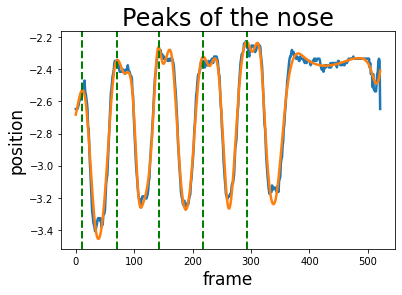

CqjNQOqS


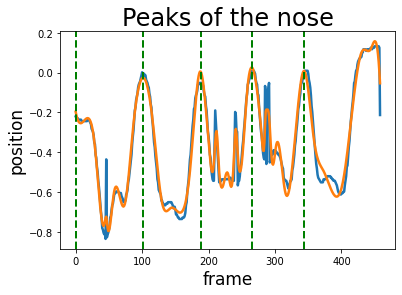

VPR8rhnq


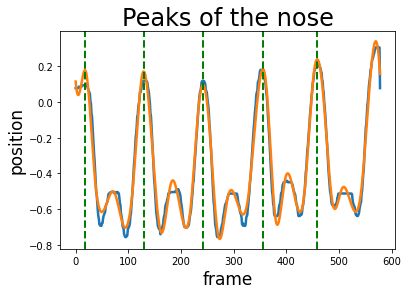

l5NH1DET


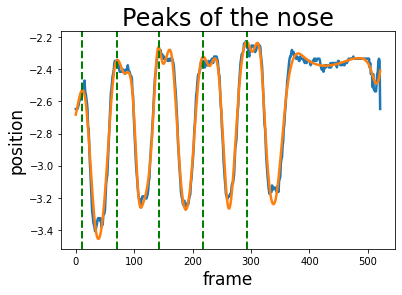

j7zyRRHu


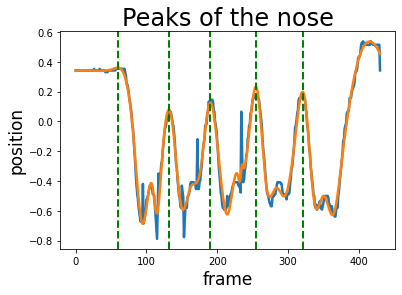

0VI1t1BZ


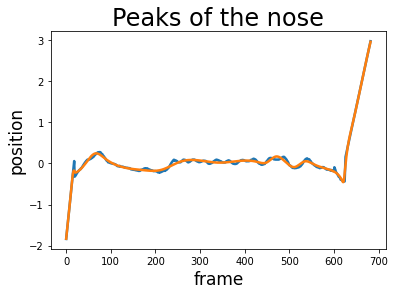

Skipped 0VI1t1BZ
7VgZ1Fni


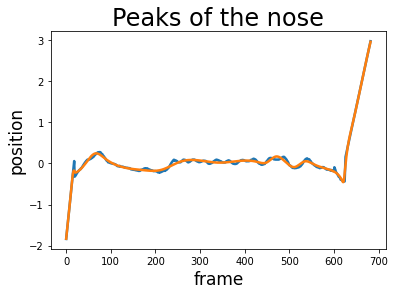

Skipped 7VgZ1Fni
wpl0CrL5


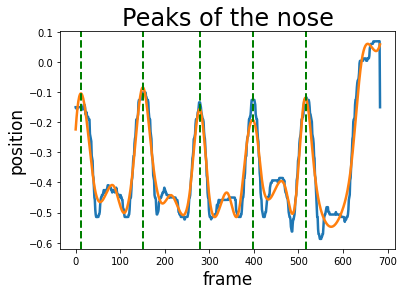

k4Zz5q1I


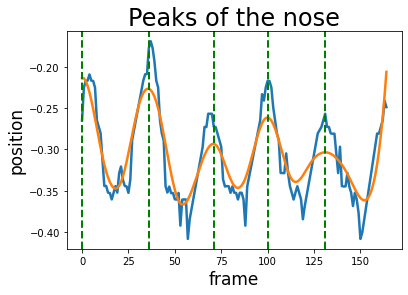

zyW3PPtt


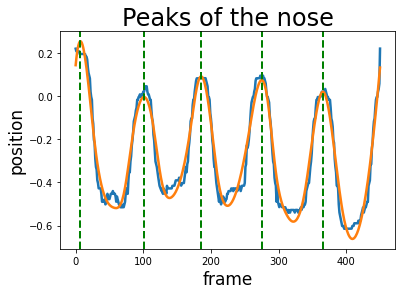

hgrLOoWj


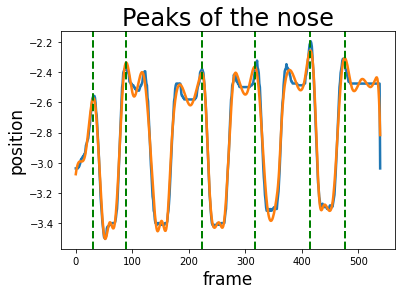

eUEXgBgU


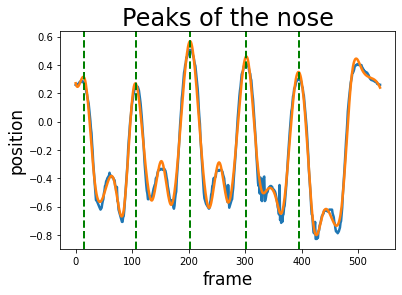

Lp9nWB3K


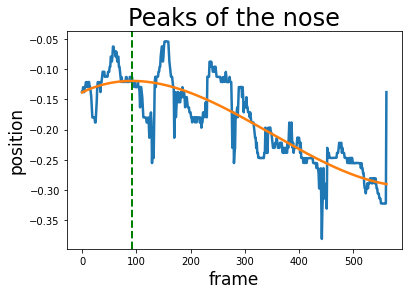

Skipped Lp9nWB3K
9hapShoY


/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


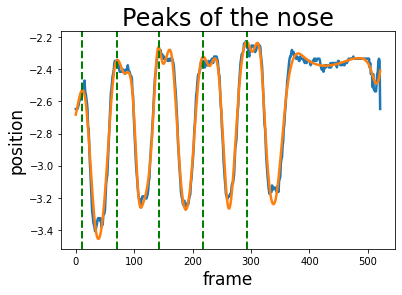

cIZijMLk


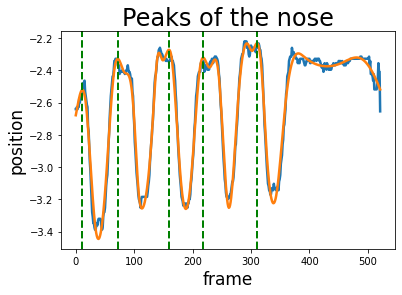

8udRElXs


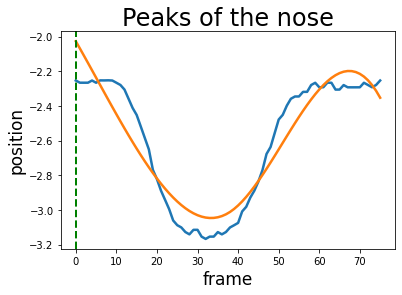

Skipped 8udRElXs
['QRGPZHlK', '0VI1t1BZ', '7VgZ1Fni', 'Lp9nWB3K', '8udRElXs']


/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kidzik/miniconda3/envs/motionlab-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [67]:
def process_subject(subjectid):
    res = np.load("videos/np/{}.npy".format(subjectid))
    
    first = 0
    last = res.shape[0]
    magnitude = 1
    
    if subjectid == "k4Zz5q1I":
        first = 75
        last = 240
        magnitude = 0.1
    if subjectid == "hozGKSGr":
        first = 60
        last = 250
        magnitude = 0.1
    if subjectid == "zyW3PPtt":
        res[res[:,NOSE*3+1] < -1,NOSE*3+1] = np.NaN
        
        
    res = res[first:last,:]

    res[res < 0.5] = np.NaN 
    res = np.apply_along_axis(fill_nan,arr=res,axis=0)
    #plt.plot(res[:,RANK])

    res = center_ts(res)
    breaks = get_segments(res, magnitude=magnitude)
    #plot_ts(res)

    results = {
        "subjectid": subjectid,
    }
    results.update(get_time_results(res, breaks))
    results.update(get_angles_results(res, breaks))
    results.update(get_acceleration_results(res, breaks))
    return results

subjects = os.listdir("videos/keypoints")
# subjects = [
#     "z7T3lqIX",
#     "k4Zz5q1I",
#     "hozGKSGr",
#     "zyW3PPtt"
# ]

skipped = []
tofix = []

all_res = []

# Convert OpenPose frames to a numpy array
for subjectid in subjects:
    print(subjectid)
    try:
        results = process_subject(subjectid)
    except Exception as e:
        skipped.append(subjectid)
        print("Skipped " + subjectid)
        continue
    all_res.append(results)    
print(skipped)

In [68]:
res_df = pd.DataFrame(all_res)
res_df

,subjectid,n,time,speed,time_sd,speed_sd,left_knee_max,left_knee_min,left_knee_max_sd,left_knee_min_sd,...,trunk_max_sd,trunk_min_sd,pelvic_avg_speed,pelvic_max_speed,pelvic_avg_acc,pelvic_max_acc,neck_avg_speed,neck_max_speed,neck_avg_acc,neck_max_acc
0,9QrMwwEK,5,18.375000,0.27,0.144097,0.011107,179.964123,98.640747,0.038094,0.395776,...,0.979081,2.030788,0.021145,0.057149,0.024765,0.080065,0.031022,0.080297,0.016234,0.039340
1,hozGKSGr,4,5.022222,1.00,0.068493,0.044243,168.158099,114.051257,1.237152,1.025721,...,1.320102,6.368131,0.038174,0.071180,0.041339,0.116243,0.042027,0.082713,0.026225,0.065324
2,0eHy4fTr,5,15.291667,0.33,0.132025,0.013844,179.700507,61.301455,0.839631,3.352651,...,6.209032,4.713119,0.071886,0.408118,0.115735,0.812577,0.031455,0.077325,0.015636,0.041182
3,BgJDWIJz,5,19.125000,0.26,0.108972,0.007324,179.969137,86.708332,2.869219,19.655168,...,4.418505,11.145888,0.087002,0.513020,0.124350,0.991676,0.062008,0.342157,0.071380,0.453018
4,bzh3pQlt,5,21.000000,0.24,0.272845,0.014899,179.994888,114.249932,0.137906,1.264493,...,0.419010,1.570058,0.031132,0.563502,0.059468,0.609611,0.020512,0.065210,0.016198,0.041291
5,OJk9GuJF,5,19.416667,0.26,0.516667,0.030589,179.988146,82.395993,0.275006,32.352640,...,2.882420,2.423459,0.089982,0.473229,0.148696,0.784851,0.042912,0.101696,0.022849,0.058050
6,z7T3lqIX,5,13.291667,0.38,0.278263,0.037910,179.728496,109.546569,4.511293,42.853341,...,0.953680,9.020720,0.112199,0.511917,0.121968,0.950254,0.050186,0.155139,0.043201,0.170279
7,iWDepaRU,5,15.291667,0.33,0.132025,0.013844,179.700507,61.301455,0.839631,3.352651,...,6.209032,4.713119,0.071886,0.408118,0.115735,0.812577,0.031455,0.077325,0.015636,0.041182
8,LK6o034V,5,21.000000,0.24,0.272845,0.014899,179.994888,114.249932,0.137906,1.264493,...,0.419010,1.570058,0.031132,0.563502,0.059468,0.609611,0.020512,0.065210,0.016198,0.041291
9,hBNwNT1A,5,15.625000,0.32,0.287107,0.027645,179.996519,93.644060,0.522073,9.142090,...,3.684778,2.953895,0.130831,0.537916,0.199499,0.856897,0.048629,0.109185,0.043458,0.121620


In [66]:
res_df.to_csv("results-new.csv")